In [1]:
!nvidia-smi

Tue Jan 13 17:44:30 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.95.05              Driver Version: 580.95.05      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 ...    Off |   00000000:01:00.0  On |                  N/A |
| N/A   42C    P8              3W /   55W |     599MiB /   8188MiB |     24%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math


import tensorflow as tf

2026-01-13 17:44:31.195020: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/vector/anaconda3/envs/gpu/lib/python3.11/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [3]:
path = "/home/vector/iitd/dataset/master_dataset/"

In [4]:
output_class = 10
batch_size = 160
img_rows = img_cols = 400
epoch = 200
channels = 3
# momentumm = 0.9252
# chanDim = -1


In [5]:
import os

CLASSES = sorted(os.listdir(path))
class_to_id = {c: i for i, c in enumerate(CLASSES)}

image_paths = []
labels = []

for cls in CLASSES:
    cls_path = os.path.join(path, cls)
    for f in os.listdir(cls_path):
        image_paths.append(os.path.join(cls_path, f))
        labels.append(class_to_id[cls])

In [6]:
len(image_paths), len(labels)

(59689, 59689)

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_tmp, y_train, y_tmp = train_test_split(
    image_paths, labels, test_size=0.3, stratify=labels, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_tmp, y_tmp, test_size=0.5, stratify=y_tmp, random_state=42
)


In [8]:
print(len(X_test), len(y_test))
print(len(X_train), len(y_train))

8954 8954
41782 41782


In [9]:
def load_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(
        img,
        channels=channels,
        expand_animations=False
    )
    img = tf.image.resize(
        img,
        (img_rows, img_cols),
        method=tf.image.ResizeMethod.BILINEAR
    )
    img = tf.cast(img, tf.float32) / 255.0
    img.set_shape((img_rows, img_cols, channels))
    return img, tf.one_hot(label, output_class)


In [10]:
def make_ds(X, y, training=False):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    ds = ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    if training:
        ds = ds.shuffle(1024)
    return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

train_ds = make_ds(X_train, y_train, True)
val_ds   = make_ds(X_val, y_val)
test_ds  = make_ds(X_test, y_test)


I0000 00:00:1768306473.357396   22704 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5551 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


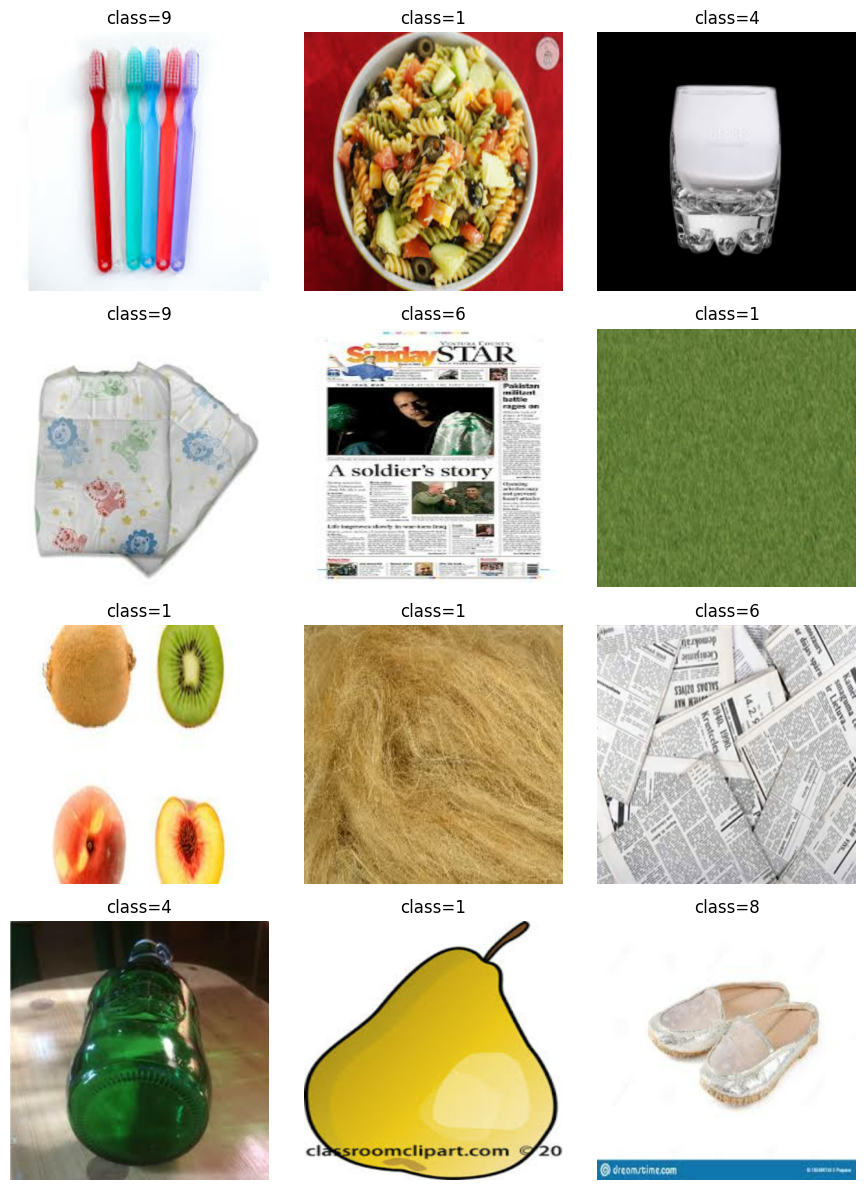

In [11]:
def plot_n_images(dataset, n):
    images, labels = next(iter(dataset))
    n = min(n, images.shape[0])

    cols = int(math.sqrt(n))
    rows = math.ceil(n / cols)

    plt.figure(figsize=(cols * 3, rows * 3))
    for i in range(n):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(images[i])
        cls = tf.argmax(labels[i]).numpy()
        plt.title(f"class={cls}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

plot_n_images(train_ds, n=12)

## Model preperation

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def build_convowaste_model(input_shape=(400, 400, 3),num_classes=10,lr=1e-4):
    base_model = InceptionResNetV2(
        weights="imagenet",
        include_top=False,
        input_shape=input_shape
    )

    # Freeze base model
    base_model.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    # Custom dense layers (as described)
    x = Dense(1080, activation="relu")(x)
    x = Dropout(0.5)(x)

    x = Dense(1080, activation="relu")(x)
    x = Dropout(0.5)(x)

    x = Dense(1080, activation="relu")(x)
    x = Dropout(0.5)(x)

    # Output layer
    outputs = Dense(num_classes, activation="softmax")(x)

    model = Model(inputs=base_model.input, outputs=outputs)

    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    return model


In [13]:
model = build_convowaste_model(
    input_shape=(img_rows, img_cols, channels),
    num_classes=output_class,
    lr=1e-4
)

# model.summary()


In [14]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau


callbacks = [
    ModelCheckpoint(
        filepath="best_model.h5",
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=False,
        verbose=1
    ),
    EarlyStopping(
        monitor="val_loss",
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.3,
        patience=7,
        min_lr=1e-6,
        verbose=1
    )
]


In [15]:
val_fraction = 0.2
train_size = int((1 - val_fraction) * len(X_train))

train_ds_final = train_ds.take(train_size)
val_ds = train_ds.skip(train_size)


In [16]:
# ensuring model fits on GPU
history = model.fit(
    train_ds_final,
    validation_data=val_ds,
    epochs=1,
    callbacks=callbacks
)


2026-01-13 17:44:47.678239: I external/local_xla/xla/service/service.cc:163] XLA service 0x70134c003720 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2026-01-13 17:44:47.678259: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2026-01-13 17:44:48.182829: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2026-01-13 17:44:51.323057: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91701
2026-01-13 17:44:52.450343: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_21501', 4 bytes spill stores, 4 bytes spill loads

2026-01-13 17:44:52.954784: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:3

261/262 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6178 - loss: 1.2006

2026-01-13 17:52:20.858311: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_21241', 12 bytes spill stores, 12 bytes spill loads



262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6184 - loss: 1.1987

2026-01-13 17:53:08.929615: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2026-01-13 17:53:08.929650: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2026-01-13 17:53:08.929665: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14374577410283627157
2026-01-13 17:53:08.929721: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16809339761987585300
/home/vector/anaconda3/envs/gpu/lib/python3.11/site-packages/keras/src/trainers/epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` funct


Epoch 1: finished saving model to best_model.h5
262/262 ━━━━━━━━━━━━━━━━━━━━ 512s 2s/step - accuracy: 0.7812 - loss: 0.7146 - learning_rate: 1.0000e-04


/home/vector/anaconda3/envs/gpu/lib/python3.11/site-packages/keras/src/callbacks/early_stopping.py:99: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)
/home/vector/anaconda3/envs/gpu/lib/python3.11/site-packages/keras/src/callbacks/callback_list.py:171: UserWarning: Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


In [17]:
# bottom layer trained on total of 3 epochs 
history = model.fit(
    train_ds_final,
    validation_data=val_ds,
    epochs=2,
    callbacks=callbacks
)


Epoch 1/2


2026-01-13 17:53:15.882843: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 307206400 bytes after encountering the first element of size 307206400 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9113 - loss: 0.2882

2026-01-13 18:00:05.817739: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2026-01-13 18:00:05.817785: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14374577410283627157
2026-01-13 18:00:05.817837: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16809339761987585300



Epoch 1: finished saving model to best_model.h5
262/262 ━━━━━━━━━━━━━━━━━━━━ 412s 2s/step - accuracy: 0.9165 - loss: 0.2725 - learning_rate: 1.0000e-04
Epoch 2/2
252/262 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.9309 - loss: 0.2226

: 

In [ ]:
# NOW, freeze the bottom layers and train the top layers with smaller batch size && reduced LR
def make_ds(X, y, training=False):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    ds = ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    if training:
        ds = ds.shuffle(1024)
    return ds.batch(64).prefetch(tf.data.AUTOTUNE)
    
train_ds = make_ds(X_train, y_train, True)
val_ds   = make_ds(X_val, y_val)
test_ds  = make_ds(X_test, y_test)


# unfreeze top layers of base model
base_model = model.get_layer("inception_resnet_v2")

base_model.trainable = True

# freeze bottom layers, train top ~100 layers
for layer in base_model.layers[:-100]:
    layer.trainable = False

# recompile with smaller LR
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [ ]:
# train
history_phase2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=callbacks,
    verbose=1
)


In [ ]:
# TRAIN ALL LAYERS
def make_ds(X, y, training=False):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    ds = ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    if training:
        ds = ds.shuffle(1024)
    return ds.batch(64).prefetch(tf.data.AUTOTUNE)
    
train_ds = make_ds(X_train, y_train, True)
val_ds   = make_ds(X_val, y_val)
test_ds  = make_ds(X_test, y_test)



# unfreeze entire base model
base_model.trainable = True

# even smaller LR
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [ ]:
history_phase3 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=callbacks,
    verbose=1
)